# Recurrent Neural Network (December 14th, 2024)

## Problem 01: Sentiment Analysis for Financial News

In [ ]:
!pip install unidecode

In [ ]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Download the dataset

In [ ]:
!gdown -c 1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q
!unzip -n dataset.zip

Skipping already downloaded file dataset.zip
Archive:  dataset.zip


### Read the dataset

In [ ]:
dataset_path='dataset/all-data.csv'
headers = ['sentiment','content']
df = pd.read_csv(dataset_path,
                 names = headers,
                 encoding='ISO-8859-1'
                )

In [ ]:
df.head()

,sentiment,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
classes = {class_name: idx for idx, class_name in enumerate(df['sentiment'].unique().tolist())}
df['sentiment'] = df['sentiment'].apply(lambda x: classes[x])
df.head()

,sentiment,content
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,1,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


### Preprocess the dataset

In [ ]:
english_stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalize(text):
  text = text.lower()
  text = unidecode.unidecode(text)
  text = text.strip()
  text = re.sub(r'[^\w\s]','', text)
  text = ' '.join([word for word in text.split(' ') if word not in english_stop_words])
  text = ' '.join([stemmer.stem(word) for word in text.split(' ')])

  return text

In [ ]:
unidecode.unidecode('áàảãạăắằẳẵặâấầẩẫậ')

'aaaaaaaaaaaaaaaaa'

In [ ]:
df['content'] = df['content'].apply(lambda x: text_normalize(x))
df.head()

,sentiment,content
0,0,accord gran compani plan move product russia ...
1,0,technopoli plan develop stage area less 100000...
2,1,intern electron industri compani elcoteq laid ...
3,2,new product plant compani would increas capac ...
4,2,accord compani updat strategi year 20092012 b...


### Build vocabulary

In [ ]:
vocab = []
for sentence in df['content'].tolist():
  tokens = sentence.split()
  for token in tokens:
    if token not in vocab:
      vocab.append(token)

vocab.append('UNK')
vocab.append('PAD')
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)

In [ ]:
def transform(text, word_to_idx, max_seq_len):
  tokens = []
  for w in text.split():
    try:
      w_ids = word_to_idx[w]
    except:
      w_ids = word_to_idx['UNK']
    tokens.append(w_ids)

  if len(tokens) < max_seq_len:
    tokens += [word_to_idx['PAD']] * (max_seq_len - len(tokens))
  elif len(tokens) > max_seq_len:
    tokens = tokens[: max_seq_len]

  return tokens

### Split `train`, `val`, and `test` sets

In [ ]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
texts = df['content'].tolist()
labels = df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(texts, labels,
                                                  test_size=val_size,
                                                  random_state=seed,
                                                  shuffle=is_shuffle)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size=val_size,
                                                    random_state=seed,
                                                    shuffle=is_shuffle)

### Build derived class from `Dataset`

In [ ]:
class FinancialNews(Dataset):
  def __init__ (self,
                X, y,
                word_to_idx,
                max_seq_len,
                transform = None):
    self.texts = X
    self.labels = y
    self.word_to_idx = word_to_idx
    self.max_seq_len = max_seq_len
    self.transform = transform

  def __len__ (self):
    return len(self.texts)

  def __getitem__ (self, idx):
    text = self.texts[idx]
    label = self.labels[idx]

    if self.transform:
      text = self.transform(text,
                            self.word_to_idx,
                            self.max_seq_len  )
      text = torch.tensor(text)

    return text, label

### Define `Dataloader` objects


In [ ]:
max_seq_len = 32

train_dataset = FinancialNews(X_train, y_train,
                              word_to_idx=word_to_idx,
                              max_seq_len=max_seq_len,
                              transform=transform)

val_dataset = FinancialNews(X_val, y_val,
                            word_to_idx=word_to_idx,
                            max_seq_len=max_seq_len,
                            transform=transform)

test_dataset = FinancialNews(X_test, y_test,
                             word_to_idx=word_to_idx,
                             max_seq_len=max_seq_len,
                             transform=transform)

In [ ]:
train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(train_dataset,
                          batch_size=train_batch_size,
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                        batch_size=test_batch_size,
                        shuffle=False)

test_loader = DataLoader(test_dataset,
                         batch_size=test_batch_size,
                         shuffle=False)

### Define the model

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__ (self, vocab_size, embedding_dim,
                hidden_size, n_layers, n_classes,
                dropout_prob):
    super(SentimentClassifier, self).__init__ ()
    # Index-based lookup table
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.rnn = nn.RNN(embedding_dim,
                      hidden_size,
                      n_layers,
                      batch_first=True)
    self.norm = nn.LayerNorm(hidden_size)
    self.dropout = nn.Dropout(dropout_prob)
    self.fc1 = nn.Linear(hidden_size, 16)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(16, n_classes)

  def forward(self, x):
    x = self.embedding(x)
    # output ([batch_size, seq_len, hidden_dims]): output for each timestep at the last layer
    # h_n ([num_layers, batch_size, hiden_dims]): output for each layer
    # output[:,-1,:] == hn[-1,:,:]
    x, hn = self.rnn(x)
    x = x[:, -1,:]
    x = self.norm(x)
    x = self.dropout(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)

    return x

In [ ]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
device='cuda' if torch.cuda.is_available() else 'cpu'

model = SentimentClassifier(vocab_size=vocab_size,
                            embedding_dim=embedding_dim,
                            hidden_size=hidden_size,
                            n_layers=n_layers,
                            n_classes=n_classes,
                            dropout_prob=dropout_prob).to(device)

### Set up loss function and optimizer

In [ ]:
lr = 1e-4
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr)

### Train the model

In [ ]:
def evaluate(model, dataloader, criterion, device):
  model.eval()
  correct = 0
  total = 0
  losses = []
  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      losses.append(loss.item())
      _, predicted = torch.max(outputs.data, 1)
      total +=labels.size(0)
      correct +=(predicted==labels).sum().item()

  loss = sum(losses) / len(losses)
  acc = correct / total

  return loss, acc

In [ ]:
def fit(model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        device,
        epochs):
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    batch_train_losses = []
    model.train()
    for idx, (inputs, labels) in enumerate(train_loader):
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      batch_train_losses.append(loss.item())

    train_loss = sum(batch_train_losses) / len(batch_train_losses)
    train_losses.append(train_loss)

    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    print(f'EPOCH {epoch + 1}: Train loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

  return train_losses, val_losses


In [ ]:
train_losses , val_losses = fit(model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        device,
        epochs)

EPOCH 1: Train loss: 1.0055	Val loss: 0.9582
EPOCH 2: Train loss: 0.9472	Val loss: 0.9345
EPOCH 3: Train loss: 0.9287	Val loss: 0.9299
EPOCH 4: Train loss: 0.9279	Val loss: 0.9290
EPOCH 5: Train loss: 0.9320	Val loss: 0.9288
EPOCH 6: Train loss: 0.9284	Val loss: 0.9290
EPOCH 7: Train loss: 0.9341	Val loss: 0.9283
EPOCH 8: Train loss: 0.9340	Val loss: 0.9283
EPOCH 9: Train loss: 0.9313	Val loss: 0.9283
EPOCH 10: Train loss: 0.9290	Val loss: 0.9283
EPOCH 11: Train loss: 0.9241	Val loss: 0.9283
EPOCH 12: Train loss: 0.9331	Val loss: 0.9281
EPOCH 13: Train loss: 0.9250	Val loss: 0.9281
EPOCH 14: Train loss: 0.9289	Val loss: 0.9281
EPOCH 15: Train loss: 0.9317	Val loss: 0.9280
EPOCH 16: Train loss: 0.9346	Val loss: 0.9280
EPOCH 17: Train loss: 0.9342	Val loss: 0.9281
EPOCH 18: Train loss: 0.9338	Val loss: 0.9279
EPOCH 19: Train loss: 0.9333	Val loss: 0.9278
EPOCH 20: Train loss: 0.9292	Val loss: 0.9277
EPOCH 21: Train loss: 0.9215	Val loss: 0.9278
EPOCH 22: Train loss: 0.9296	Val loss: 0.92

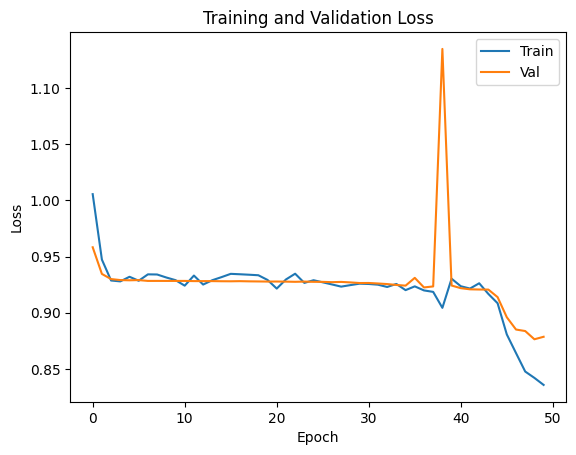

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Evaluate the model

In [ ]:
val_loss, val_acc = evaluate(model,
                             val_loader,
                             criterion,
                             device)

test_loss, test_acc = evaluate(model,
                               test_loader,
                               criterion,
                               device)

print('Evaluation on val/test dataset')
print('Val accuracy:', val_acc)
print('Test accuracy:', test_acc)

Evaluation on val/test dataset
Val accuracy: 0.6257731958762887
Test accuracy: 0.6327319587628866


### LSTM variant

In [ ]:
class SentimentClassifier_LSTM(nn.Module):
  def __init__ (self, vocab_size, embedding_dim,
                hidden_size, n_layers, n_classes,
                dropout_prob):
    super(SentimentClassifier_LSTM, self).__init__ ()
    # Index-based lookup table
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.rnn = nn.LSTM(embedding_dim,
                      hidden_size,
                      n_layers,
                      batch_first=True)
    self.norm = nn.LayerNorm(hidden_size)
    self.dropout = nn.Dropout(dropout_prob)
    self.fc1 = nn.Linear(hidden_size, 16)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(16, n_classes)

  def forward(self, x):
    x = self.embedding(x)
    # output ([batch_size, seq_len, hidden_dims]): output for each timestep at the last layer
    # h_n ([num_layers, batch_size, hiden_dims]): output for each layer
    # output[:,-1,:] == hn[-1,:,:]
    x, hn = self.rnn(x)
    x = x[:, -1,:]
    x = self.norm(x)
    x = self.dropout(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)

    return x

In [ ]:
model = SentimentClassifier_LSTM(vocab_size=vocab_size,
                            embedding_dim=embedding_dim,
                            hidden_size=hidden_size,
                            n_layers=n_layers,
                            n_classes=n_classes,
                            dropout_prob=dropout_prob).to(device)

optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr)

In [ ]:
train_losses , val_losses = fit(model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        device,
        epochs)

EPOCH 1: Train loss: 1.0501	Val loss: 0.9776
EPOCH 2: Train loss: 0.9601	Val loss: 0.9375
EPOCH 3: Train loss: 0.9321	Val loss: 0.9286
EPOCH 4: Train loss: 0.9350	Val loss: 0.9270
EPOCH 5: Train loss: 0.9323	Val loss: 0.9269
EPOCH 6: Train loss: 0.9330	Val loss: 0.9268
EPOCH 7: Train loss: 0.9373	Val loss: 0.9268
EPOCH 8: Train loss: 0.9254	Val loss: 0.9269
EPOCH 9: Train loss: 0.9407	Val loss: 0.9268
EPOCH 10: Train loss: 0.9310	Val loss: 0.9269
EPOCH 11: Train loss: 0.9280	Val loss: 0.9266
EPOCH 12: Train loss: 0.9251	Val loss: 0.9266
EPOCH 13: Train loss: 0.9325	Val loss: 0.9267
EPOCH 14: Train loss: 0.9308	Val loss: 0.9267
EPOCH 15: Train loss: 0.9310	Val loss: 0.9266
EPOCH 16: Train loss: 0.9333	Val loss: 0.9265
EPOCH 17: Train loss: 0.9289	Val loss: 0.9265
EPOCH 18: Train loss: 0.9267	Val loss: 0.9263
EPOCH 19: Train loss: 0.9254	Val loss: 0.9262
EPOCH 20: Train loss: 0.9218	Val loss: 0.9261
EPOCH 21: Train loss: 0.9251	Val loss: 0.9259
EPOCH 22: Train loss: 0.9395	Val loss: 0.92

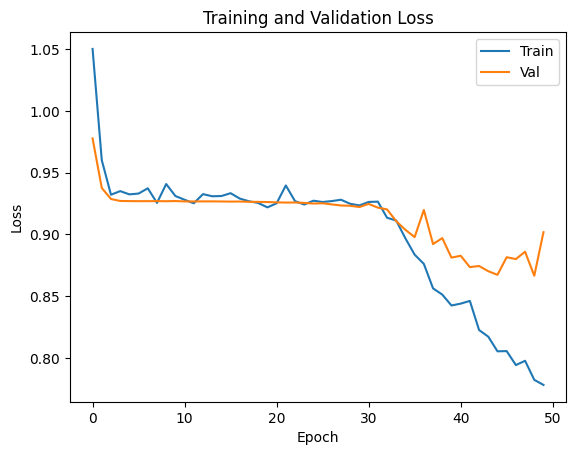

In [ ]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
val_loss, val_acc = evaluate(model,
                             val_loader,
                             criterion,
                             device)

test_loss, test_acc = evaluate(model,
                               test_loader,
                               criterion,
                               device)

print('Evaluation on val/test dataset')
print('Val accuracy:', val_acc)
print('Test accuracy:', test_acc)

Evaluation on val/test dataset
Val accuracy: 0.5938144329896907
Test accuracy: 0.6018041237113402


### BiLSTM variant

In [ ]:
class SentimentClassifier_BiLSTM(nn.Module):
  def __init__ (self, vocab_size, embedding_dim,
                hidden_size, n_layers, n_classes,
                dropout_prob):
    super(SentimentClassifier_BiLSTM, self).__init__ ()
    # Index-based lookup table
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.rnn = nn.LSTM(embedding_dim,
                      hidden_size,
                      n_layers,
                      batch_first=True,
                      bidirectional=True)
    self.norm = nn.LayerNorm(2*hidden_size)
    self.dropout = nn.Dropout(dropout_prob)
    self.fc1 = nn.Linear(2*hidden_size, 16)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(16, n_classes)

  def forward(self, x):
    x = self.embedding(x)
    # output ([batch_size, seq_len, hidden_dims]): output for each timestep at the last layer
    # h_n ([num_layers, batch_size, hiden_dims]): output for each layer
    # output[:,-1,:] == hn[-1,:,:]
    x, hn = self.rnn(x)
    x = x[:, -1,:]
    x = self.norm(x)
    x = self.dropout(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)

    return x

In [ ]:
model = SentimentClassifier_BiLSTM(vocab_size=vocab_size,
                            embedding_dim=embedding_dim,
                            hidden_size=hidden_size,
                            n_layers=n_layers,
                            n_classes=n_classes,
                            dropout_prob=dropout_prob).to(device)

optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr)

In [ ]:
train_losses , val_losses = fit(model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        device,
        epochs)

EPOCH 1: Train loss: 1.0212	Val loss: 0.9310
EPOCH 2: Train loss: 0.9302	Val loss: 0.9294
EPOCH 3: Train loss: 0.9330	Val loss: 0.9277
EPOCH 4: Train loss: 0.9370	Val loss: 0.9275
EPOCH 5: Train loss: 0.9247	Val loss: 0.9271
EPOCH 6: Train loss: 0.9362	Val loss: 0.9270
EPOCH 7: Train loss: 0.9360	Val loss: 0.9265
EPOCH 8: Train loss: 0.9306	Val loss: 0.9266
EPOCH 9: Train loss: 0.9337	Val loss: 0.9260
EPOCH 10: Train loss: 0.9308	Val loss: 0.9258
EPOCH 11: Train loss: 0.9333	Val loss: 0.9258
EPOCH 12: Train loss: 0.9269	Val loss: 0.9256
EPOCH 13: Train loss: 0.9265	Val loss: 0.9248
EPOCH 14: Train loss: 0.9268	Val loss: 0.9268
EPOCH 15: Train loss: 0.9306	Val loss: 0.9245
EPOCH 16: Train loss: 0.9265	Val loss: 0.9241
EPOCH 17: Train loss: 0.9229	Val loss: 0.9236
EPOCH 18: Train loss: 0.9309	Val loss: 0.9238
EPOCH 19: Train loss: 0.9186	Val loss: 0.9217
EPOCH 20: Train loss: 0.9163	Val loss: 0.9181
EPOCH 21: Train loss: 0.9116	Val loss: 0.9216
EPOCH 22: Train loss: 0.8975	Val loss: 0.91

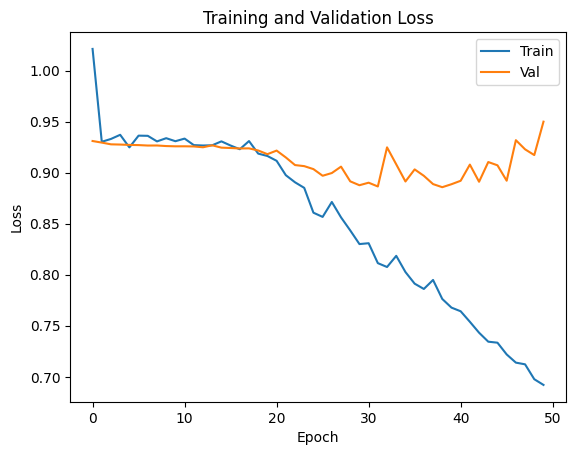

In [ ]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
val_loss, val_acc = evaluate(model,
                             val_loader,
                             criterion,
                             device)

test_loss, test_acc = evaluate(model,
                               test_loader,
                               criterion,
                               device)

print('Evaluation on val/test dataset')
print('Val accuracy:', val_acc)
print('Test accuracy:', test_acc)

Evaluation on val/test dataset
Val accuracy: 0.565979381443299
Test accuracy: 0.5425257731958762


## Problem 02: Hourly Temperature Forecasting

### Import dependencies

In [ ]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

### Download the dataset

In [ ]:
!gdown -c 178YSDYmlRh54IcxStgYA3UyKFRM9-3DO
!unzip -n dataset.zip

Skipping already downloaded file dataset.zip
Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/weatherHistory.csv  


### Read and preprocess the dataset

In [ ]:
dataset_filepath= 'dataset/weatherHistory.csv'
df = pd.read_csv(dataset_filepath)

In [ ]:
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [ ]:
univariate_df = df['Temperature (C)']
univariate_df.index = df['Formatted Date']
univariate_df.head()

,Temperature (C)
Formatted Date,
2006-04-01 00:00:00.000 +0200,9.472222
2006-04-01 01:00:00.000 +0200,9.355556
2006-04-01 02:00:00.000 +0200,9.377778
2006-04-01 03:00:00.000 +0200,8.288889
2006-04-01 04:00:00.000 +0200,8.755556


In [ ]:
input_size = 6
label_size = 1
offset = 1

def slicing_window(df,
                   df_start_idx, df_end_idx,
                   input_size, label_size, offset):
  features = []
  labels = []

  window_size = input_size + offset

  if df_end_idx == None:
    df_end_idx = len(df) - window_size

  for idx in range(df_start_idx, df_end_idx):
    feature_end_idx = idx + input_size
    label_start_idx = idx + window_size - label_size

    feature = df[idx:feature_end_idx]
    label = df[label_start_idx:(idx+window_size)]

    features.append(feature)
    labels.append(label)

  features = np.expand_dims(np.array(features), -1)
  labels = np.array(labels)

  return features, labels

### Split `train`, `val`, and `test` sets

In [ ]:
dataset_length = len(univariate_df)
train_size = 0.7
val_size = 0.2
train_end_idx = int(train_size * dataset_length)
val_end_idx = int(val_size * dataset_length) + train_end_idx

X_train, y_train = slicing_window(univariate_df,
                                  df_start_idx=0,
                                  df_end_idx=train_end_idx,
                                  input_size=input_size,
                                  label_size=label_size,
                                  offset=offset)

X_val, y_val = slicing_window(univariate_df,
                              df_start_idx=train_end_idx,
                              df_end_idx=val_end_idx,
                              input_size=input_size,
                              label_size=label_size,
                              offset=offset)

X_test, y_test = slicing_window(univariate_df,
                                df_start_idx=val_end_idx,
                                df_end_idx=None,
                                input_size=input_size,
                                label_size=label_size,
                                offset=offset)

### Build derived class from Dataset

In [ ]:
class WeatherForecast(Dataset):
  def __init__ (self, X, y, transform = None ):
    self.X = X
    self.y = y
    self.transform = transform

  def __len__ (self):
    return len(self.X)

  def __getitem__ (self, idx):
    X = self.X[idx]
    y = self.y[idx]

    if self.transform:
      X = self.transform(X)

    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    return X, y

### Define Dataloader objects

In [ ]:
train_dataset = WeatherForecast(X_train, y_train)
val_dataset = WeatherForecast(X_val, y_val)
test_dataset = WeatherForecast(X_test, y_test)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(train_dataset,
                          batch_size=train_batch_size,
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                        batch_size=test_batch_size,
                        shuffle = False)

test_loader = DataLoader(test_dataset,
                         batch_size=test_batch_size,
                         shuffle=False)

### Define the model

In [ ]:
class WeatherForecastor(nn.Module):
  def __init__ (  self, embedding_dim, hidden_size,  n_layers, dropout_prob):
    super(WeatherForecastor, self).__init__ ()
    self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
    self.norm = nn.LayerNorm(hidden_size)

    self.dropout = nn.Dropout(dropout_prob)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    x, hn = self.rnn(x)
    x = x[:, -1,:]
    x = self.norm(x)
    x = self.dropout(x)
    x = self.fc(x)

    return x

In [ ]:
embedding_dim = 1
hidden_size = 8
n_layers = 3
dropout_prob = 0.2
device= 'cuda' if torch.cuda.is_available() else 'cpu'

model = WeatherForecastor(embedding_dim=embedding_dim,
                          hidden_size=hidden_size,
                          n_layers=n_layers,
                          dropout_prob=dropout_prob).to(device)

### Set up loss function and optimizer

In [ ]:
lr = 1e-3
epochs = 50

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr)

### Train the model

In [ ]:
def evaluate(model, dataloader, criterion, device):
  model.eval()
  correct = 0
  total = 0
  losses = []
  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      losses.append(loss.item())

  loss = sum(losses) / len(losses)

  return loss

In [ ]:
def fit(model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        device,
        epochs):
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    batch_train_losses = []
    model.train()
    for idx, (inputs, labels) in enumerate(train_loader):
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      batch_train_losses.append(loss.item())

    train_loss = sum(batch_train_losses) / len(batch_train_losses)
    train_losses.append(train_loss)

    val_loss = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    print(f'EPOCH {epoch + 1}: Train loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

  return train_losses, val_losses


In [ ]:
train_losses , val_losses = fit(model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        device,
        epochs)

EPOCH 1: Train loss: 126.7142	Val loss: 41.0007
EPOCH 2: Train loss: 29.9090	Val loss: 7.3284
EPOCH 3: Train loss: 16.1272	Val loss: 3.4280
EPOCH 4: Train loss: 13.1546	Val loss: 3.0714
EPOCH 5: Train loss: 11.6121	Val loss: 2.1859
EPOCH 6: Train loss: 10.6030	Val loss: 1.8862
EPOCH 7: Train loss: 10.1788	Val loss: 1.7658
EPOCH 8: Train loss: 9.6496	Val loss: 1.8411
EPOCH 9: Train loss: 9.3395	Val loss: 2.0071
EPOCH 10: Train loss: 9.1364	Val loss: 1.6806
EPOCH 11: Train loss: 8.8933	Val loss: 1.5724
EPOCH 12: Train loss: 8.8007	Val loss: 1.5614
EPOCH 13: Train loss: 8.4926	Val loss: 2.1140
EPOCH 14: Train loss: 8.4098	Val loss: 1.8371
EPOCH 15: Train loss: 8.2467	Val loss: 1.6703
EPOCH 16: Train loss: 7.8909	Val loss: 1.9196
EPOCH 17: Train loss: 7.8164	Val loss: 1.5569
EPOCH 18: Train loss: 7.7345	Val loss: 1.9944
EPOCH 19: Train loss: 7.5005	Val loss: 1.5792
EPOCH 20: Train loss: 7.4500	Val loss: 1.5611
EPOCH 21: Train loss: 7.2653	Val loss: 1.9266
EPOCH 22: Train loss: 7.0327	Val l

### Evaluate the model

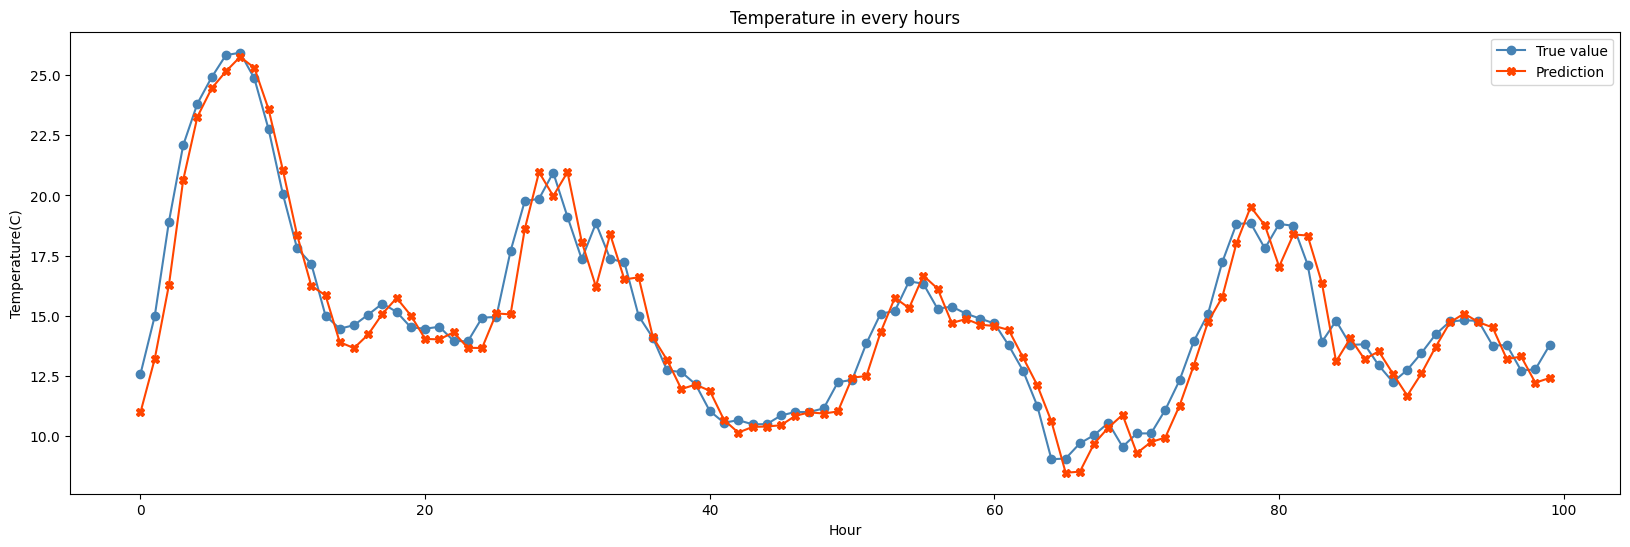

In [ ]:
def plot_difference(y, pred):
  plt.figure(figsize=(20, 6))
  times = range(len(y))
  y_to_plot = y.flatten()
  pred_to_plot = pred.flatten()

  plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
  plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

  plt.title('Temperature in every hours')
  plt.xlabel('Hour')
  plt.ylabel('Temperature(C)')
  plt.legend()
  plt.show()

inputs = torch.tensor(X_test[:100], dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
  outputs = model(inputs).detach().cpu().numpy()
plot_difference(y_test[:100], outputs)

### LSTM variant

In [ ]:
class WeatherForecastor_LSTM(nn.Module):
  def __init__ (  self, embedding_dim, hidden_size,  n_layers, dropout_prob):
    super(WeatherForecastor_LSTM, self).__init__ ()
    self.rnn = nn.LSTM(embedding_dim, hidden_size, n_layers, batch_first=True)
    self.norm = nn.LayerNorm(hidden_size)

    self.dropout = nn.Dropout(dropout_prob)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    x, hn = self.rnn(x)
    x = x[:, -1,:]
    x = self.norm(x)
    x = self.dropout(x)
    x = self.fc(x)

    return x

In [ ]:
model = WeatherForecastor_LSTM(embedding_dim=embedding_dim,
                          hidden_size=hidden_size,
                          n_layers=n_layers,
                          dropout_prob=dropout_prob).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr)

In [ ]:
train_losses , val_losses = fit(model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        device,
        epochs)

EPOCH 1: Train loss: 28.1280	Val loss: 7.0348
EPOCH 2: Train loss: 14.2460	Val loss: 3.0716
EPOCH 3: Train loss: 11.5127	Val loss: 2.2193
EPOCH 4: Train loss: 10.5754	Val loss: 2.1535
EPOCH 5: Train loss: 10.0438	Val loss: 1.7162
EPOCH 6: Train loss: 9.6933	Val loss: 2.3751
EPOCH 7: Train loss: 9.4158	Val loss: 2.3893
EPOCH 8: Train loss: 9.2695	Val loss: 1.7593
EPOCH 9: Train loss: 9.1208	Val loss: 1.8683
EPOCH 10: Train loss: 8.9339	Val loss: 2.0508
EPOCH 11: Train loss: 8.5563	Val loss: 1.6892
EPOCH 12: Train loss: 8.4560	Val loss: 1.5736
EPOCH 13: Train loss: 8.1991	Val loss: 1.5386
EPOCH 14: Train loss: 8.0245	Val loss: 1.6586
EPOCH 15: Train loss: 7.8506	Val loss: 2.1775
EPOCH 16: Train loss: 7.7547	Val loss: 1.7978
EPOCH 17: Train loss: 7.5208	Val loss: 1.5831
EPOCH 18: Train loss: 7.3557	Val loss: 1.6381
EPOCH 19: Train loss: 7.2601	Val loss: 1.5763
EPOCH 20: Train loss: 7.0833	Val loss: 1.5820
EPOCH 21: Train loss: 6.9401	Val loss: 1.4749
EPOCH 22: Train loss: 6.9468	Val loss:

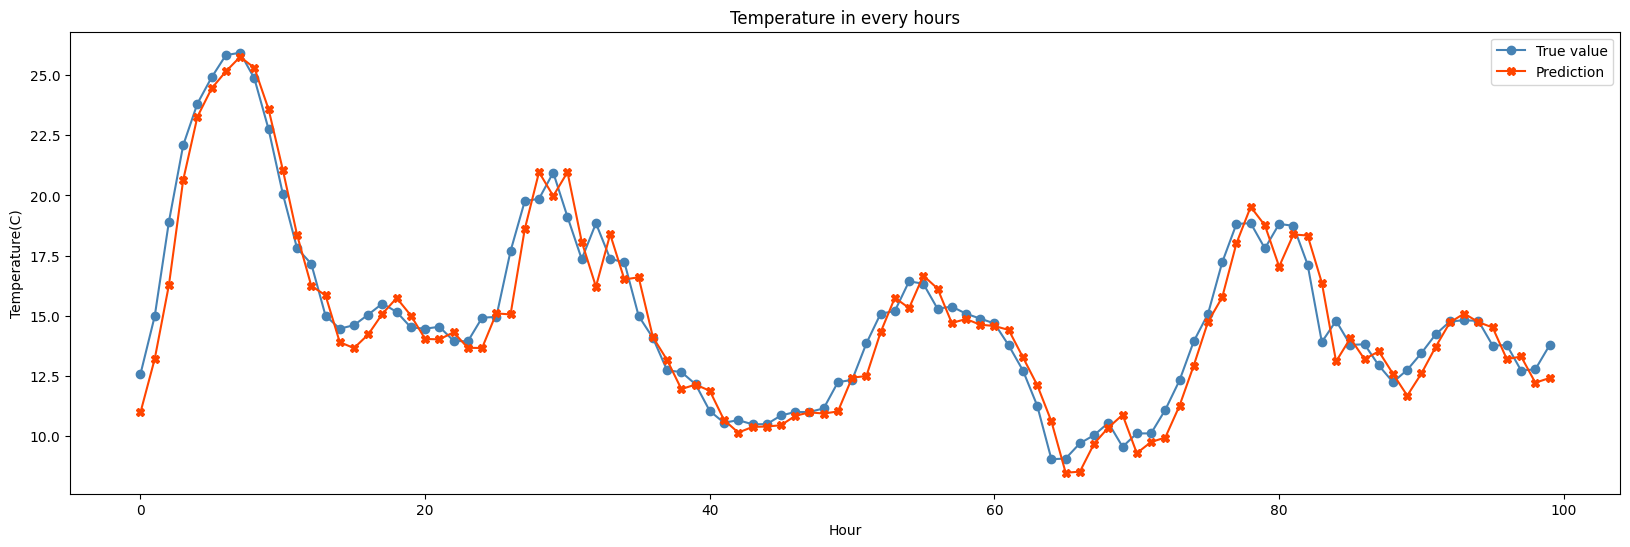

In [ ]:
def plot_difference(y, pred):
  plt.figure(figsize=(20, 6))
  times = range(len(y))
  y_to_plot = y.flatten()
  pred_to_plot = pred.flatten()

  plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
  plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

  plt.title('Temperature in every hours')
  plt.xlabel('Hour')
  plt.ylabel('Temperature(C)')
  plt.legend()
  plt.show()

inputs = torch.tensor(X_test[:100], dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
  outputs = model(inputs).detach().cpu().numpy()
plot_difference(y_test[:100], outputs)

### BiLSTM variant

In [ ]:
class WeatherForecastor_BiLSTM(nn.Module):
  def __init__ (  self, embedding_dim, hidden_size,  n_layers, dropout_prob):
    super(WeatherForecastor_BiLSTM, self).__init__ ()
    self.rnn = nn.LSTM(embedding_dim, hidden_size, n_layers, batch_first=True, bidirectional=True)
    self.norm = nn.LayerNorm(2*hidden_size)

    self.dropout = nn.Dropout(dropout_prob)
    self.fc = nn.Linear(2*hidden_size, 1)

  def forward(self, x):
    x, hn = self.rnn(x)
    x = x[:, -1,:]
    x = self.norm(x)
    x = self.dropout(x)
    x = self.fc(x)

    return x

In [ ]:
model = WeatherForecastor_BiLSTM(embedding_dim=embedding_dim,
                          hidden_size=hidden_size,
                          n_layers=n_layers,
                          dropout_prob=dropout_prob).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr)

In [ ]:
train_losses , val_losses = fit(model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        device,
        epochs)

EPOCH 1: Train loss: 86.2602	Val loss: 12.8304
EPOCH 2: Train loss: 12.1366	Val loss: 3.1206
EPOCH 3: Train loss: 7.6623	Val loss: 2.0495
EPOCH 4: Train loss: 6.7450	Val loss: 1.6429
EPOCH 5: Train loss: 6.3637	Val loss: 1.8370
EPOCH 6: Train loss: 6.1372	Val loss: 1.8031
EPOCH 7: Train loss: 6.0126	Val loss: 1.8912
EPOCH 8: Train loss: 5.9288	Val loss: 1.5638
EPOCH 9: Train loss: 5.8127	Val loss: 1.7426
EPOCH 10: Train loss: 5.6516	Val loss: 1.5293
EPOCH 11: Train loss: 5.6240	Val loss: 1.6172
EPOCH 12: Train loss: 5.5592	Val loss: 1.6033
EPOCH 13: Train loss: 5.4251	Val loss: 1.6339
EPOCH 14: Train loss: 5.3944	Val loss: 1.5583
EPOCH 15: Train loss: 5.3571	Val loss: 1.5269
EPOCH 16: Train loss: 5.2151	Val loss: 1.5277
EPOCH 17: Train loss: 5.1300	Val loss: 1.5477
EPOCH 18: Train loss: 5.0670	Val loss: 1.4696
EPOCH 19: Train loss: 5.0126	Val loss: 1.5393
EPOCH 20: Train loss: 4.8802	Val loss: 1.6342
EPOCH 21: Train loss: 4.8821	Val loss: 1.5164
EPOCH 22: Train loss: 4.7407	Val loss: 1

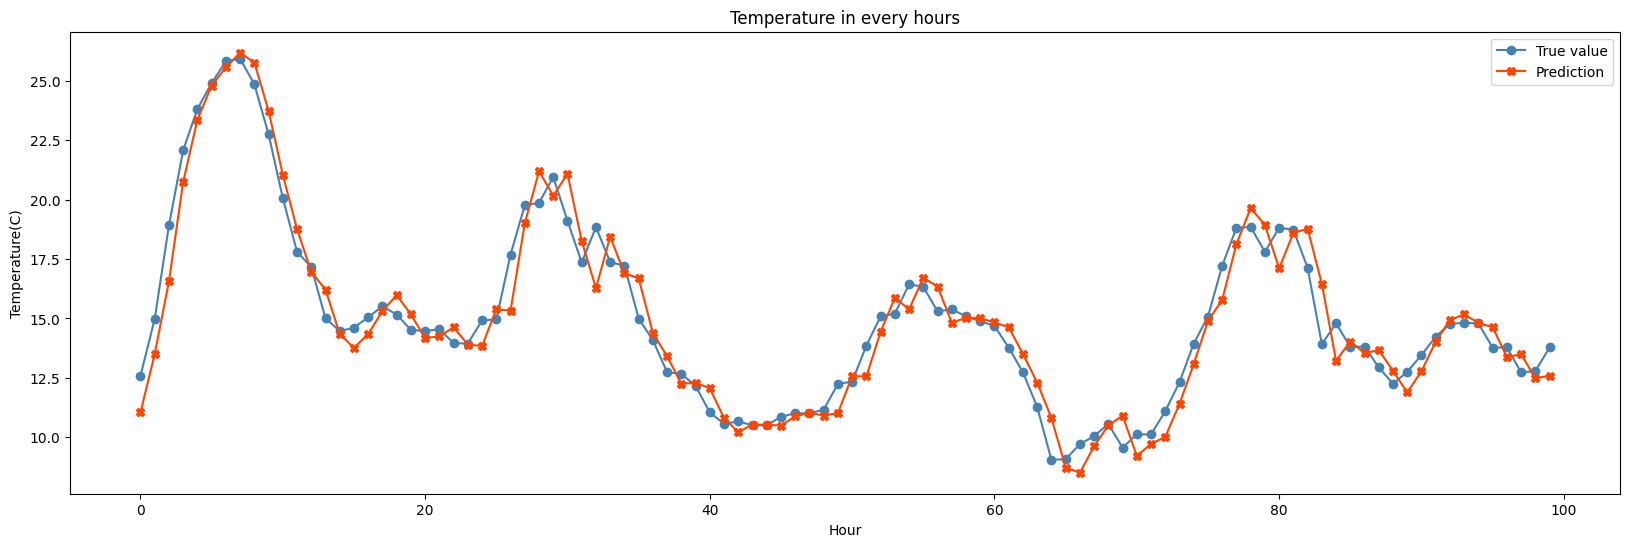

In [ ]:
def plot_difference(y, pred):
  plt.figure(figsize=(20, 6))
  times = range(len(y))
  y_to_plot = y.flatten()
  pred_to_plot = pred.flatten()

  plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
  plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

  plt.title('Temperature in every hours')
  plt.xlabel('Hour')
  plt.ylabel('Temperature(C)')
  plt.legend()
  plt.show()

inputs = torch.tensor(X_test[:100], dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
  outputs = model(inputs).detach().cpu().numpy()
plot_difference(y_test[:100], outputs)